# Linear Regression

### The Normal Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generating some linear looking data to test the Normal Equation 

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

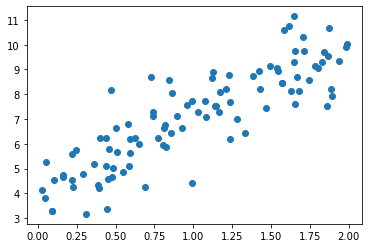

In [3]:
%matplotlib inline
plt.scatter(X, y)
plt.show()

Using the **inv()** function from NumPy's *linalg* module, to compute the inverse of a matrix and the **dot()** method for matrix multiplication

In [4]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

The fucntion that we used to generate the data is y = 4 + 3x + Gaussian noise.

The parameters the normal equation found are:

In [5]:
theta_best

array([[4.12821347],
       [2.94100515]])

We would have hoped for $\theta_{0}$ to be exactly 4 instead of 4.128... and for $\theta_{1}$ to be exactly 3 instead of 2.941... but the Gaussian noise made it impossible to recover the exact parameters of the original function.

Now we can make predictions using $\hat{\theta}$:

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.12821347],
       [10.01022377]])

Plotting the model's predictions

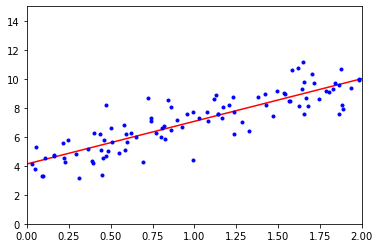

In [7]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

We can perform LinearRegression using Scikit-Learn as well:

(Scikit-Learn separates the bias term (*intercept_*) from the feature weights (*coef_*))

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.12821347]), array([[2.94100515]]))

In [9]:
lin_reg.predict(X_new)

array([[ 4.12821347],
       [10.01022377]])

The **LinearRegression** class is based on the *scipy.linalg.lstsq()* function (least squares function), which can be called directly like so:

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.12821347],
       [2.94100515]])

This function computes $\hat{\theta} = X^{+} y$, where $X^{+}$ is the *pseudoinverse* of **X** (specifically the Moore-Penrose inverse). 

We can use the *np.linalg.pinv()* function to compute the pseudoinverse directly:

In [11]:
np.linalg.pinv(X_b).dot(y)

array([[4.12821347],
       [2.94100515]])

The pseudoinverse itself is computed using a standard matrix factorization technique called *Singular Value Decomposition* (SVD) that can decompose the training set matrix **X** into the matrix multiplication of three matrices **$U \Sigma V^{T}$** (*numpy.linalg.svd()*). The pseudoinverse is computed as $X^{+} = V \Sigma^{+} U^{T}$. To compute the matrix $\Sigma^{+}$, the algorithm takes $\Sigma$ and sets to zero all values smaller than a tiny threshold value, then it replaces all the nonzero values with their inverse, and finally it transposes the resulting matrix. This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely. The Normal Equation may not work if the matrix $X^{T}X$ is not invertible (singluar), such as if *m < n* or if some features are redundant, but the pseudoinverse is always defined.  

### Computational Complexity

The Normal Equation computes the inverse of $X^{T}X$, which is an (n+1) x (n+1) matrix (n is the number of features). The computation complexity of inverting such a matrix is usually about $O(n^{2.4})$ to $O(n^{3})$, depending on the implementation. If we double the number of features it will multiply the computation time by roughly $2^{2.4} = 5.3$ to $2^{3} = 8$.

The SVD approach used the the *LinearRegression* class is about $O(n^{2})$. If we double the number of features, it increases computation time by roughly 4.

Both the Normal Equation and SVD approach get very slow when the number of features grow large. On the positive side, both are linear with regard to the number of instances in the training set, so they can handle large training sets efficiently provided they can fit in memory.

Once we have trained our LinearRegression model (using Normal Equation or any other method), predictions are very fast. The computational complexity is linear with respect to both number of instances we want to make predictions on and the number of features. 

We shall look at a different way to train our Linear Regression model, one that is suited for cases where there are a large number of features or too many training instances to fit in memory.

# Gradient Descent

Gradient Descent works by taking a step in the direction of the steepest descent. It works very well on convex functions (MSE) and can find the global minimum if we wait long enough and the learning rate is not too large. 

Gradient Descent may not work as well in functions that have plateaus and several local minima. The random initialization may be such that it can get stcuk in local minima or may get stuck slowly descending a plateau.

When using Gradient Descent, we must ensure that all features have a similar scale (using Scikit-Learn's *StandardScaler*), or else Gradient Descent will take much longer to converge.

### Batch Gradient Descent

To implement Gradient Descent, we need to compute the gradient of the cost function with respect to each model parameter $\theta_{j}$. This is called a *partial derivative*. This is given by:

$\frac{\partial}{\partial \theta_{j}} MSE(\theta) = \frac{2}{m} \sum_{i=1}^{m} (\theta^{T} x^{(i)} - y^{(i)}) x_{j}^{(i)}$

Instead of computing these partial derivatives individually, we can use the gradient vector form denoted $\triangledown_{\theta} MSE(\theta) = \frac{2}{m} X^{T} (X \theta - y) $

This formula involves calculations over the full training set **X** at each Gradient Step. This is why the algorithm is called *Batch Gradient Descent*. This makes it awfully slow on very large training sets.

Once we have the gradient vector, calculating the updated parameters is as simple as:

$\theta^{(next step)} = \theta - \eta \triangledown_{\theta} MSE (\theta)$

In [12]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) #random intialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

The parameters are the exact same as found by the Normal Equation.

In [13]:
theta

array([[4.12821347],
       [2.94100515]])

To find a good learning rate, we can use Grid Search with a limited number of iterations so that grid search can eliminate models that take too long to converge.

As for the number of iterations, we can set a very large number of iterations and interrupt the algorithm when the gradient vector becomes tiny, i.e., when its norm becomes smaller than a tiny number $\epsilon$ (called the *tolerance*), because when this happens, Gradient Descent has almost reached the minimum.

### Stochastic Gradient Descent

The problem with Batch Gradient Descent was that we were computing the gradient vector for the entire training set at a time which made it very slow. However, in Stochastic Gradient Descent, we only train one instance at a time. This makes computation significantly faster and can be carried out as an out-of-core algorithm too.

On the other hand, due to its stochastic (random) nature, SGD is much less regular than Batch GD. Instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Over time, it will end up very close to the minimum, but once it gets there, it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good but not optimal.

When the cost function is very irregular (not perfectly convex like the MSE), this can actually help the algorithm jump out of local minima, so SGD has a better chance of finding the global minima than Batch GD.

Thus, randomness is good to escape from local optima but bad because it means that the algorithm can never settle at the minimum. One solution to this dilemma is to gradually decrease the learning rate (similar to *simulated annealing*). The function that determines the learning rate at each iteration is called the *learning schedule*. 

In [14]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

By convention, we iterate by rounds of *m* iterations; each round is called an *epoch*.

While the Batch GD code iterated 1000 times over the entire training set, SGD goes through the entire training set only 50 times and reached a pretty good solution.

In [15]:
theta

array([[4.10094757],
       [2.9156568 ]])

While using SGD, the training instances must be independent and identically distributed (iid) to ensure that the parameters get pulled toward the global optimum on average. A simple way to ensure this is to shuffle the instances during training (either pick each instance randomly or shuffle the training set at the beginning of each epoch). If we do not shuffle the instances and by example say - the instances are sorted by label - then SGD will start optimizing by for one label, then the next and so on, and it will not settle close to the global minimum.

To perform Linear Regression using SGD with Scikit-Learn, we can use the **SGDRegressor** class, which defaults to optimizing the squared error cost function. 

The following code runs for maximum 1000 epochs or until the loss drops by less than 0.001 during one epoch (**max_iter=1000, tol=1e-3**). It starts with a learnin rate of 0.1 (**eta0=0.1**), using the default learning schedule (different from the preceding one). Lastly, it does not use any regularization (**penalty=None**)

In [16]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [17]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.13133005]), array([3.00140404]))

Once again, we find a solution very close to the one we found using the Normal Equation

### Mini-batch Gradient Descent

At each step, instead of computing the gradients based on the full training set (as in Batch DG) or on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called *mini-batches*. The main advantage of Mini-batch GD over SGD is that we get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm's progress in the parameter space is less erratic than SGD especially with fairly large mini-batches. As a result, Mini-batch GD will end up walking closer to the minima than SGD but it may be harder to escape from local minima. 

If we compare all three algorithms, we notice that Batch GD's path actually stops at the minima while the other two walk around the minima. However, Batch GD takes a lot of time and both SGD and Mini-batch GD can also converge close enough to the minima if we use a good learning schedule.

*Comparison of algorithms for Linear Regression*

| Algorithm | Large m | Out-of-core support | Large n | Hyperparameters | Scaling required | Scikit-Learn |
  | --------- | :------- | :------------------- | :------- | :--------------- | :---------------- | :------------ |
  | Normal Equation | Fast | No | Slow | 0 | No | N/A |
  | SVD | Fast | No | Slow | 0 | No | LinearRegression |
  | Batch GD | Slow | No | Fast | 2 | Yes | SGDRegressor |
  | Stochastic GD | Fast | Yes | Fast | $\geq$ 2 | Yes | SGDRegressor |
  | Mini-batch GD | Fast | Yes | Fast | $\geq$ 2 | Yes | SGDRegressor |

There is almost no difference after training: all algorithms end up with very similar models and make predictions in exactly the same way.

# Polynomial Regression

If our data is more complex than a straight line, we can use a linear model to fit non-linear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called *Polynomial Regression*.

Generating some nonlinear data based on a simple *quadratic equation*:

$y = ax^{2} + bx + c$

In [18]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

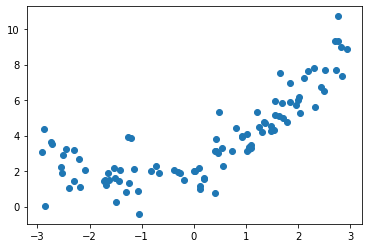

In [19]:
plt.scatter(X, y)
plt.show()

Clearly, a linear model cannot fit this data properly. So we use Scikit-Learn's **PolynomialFeatures** class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([1.37151979])

In [21]:
X_poly[0]

array([1.37151979, 1.88106653])

In [22]:
lin_reg = LinearRegression()

In [23]:
lin_reg.fit(X_poly, y)

LinearRegression()

In [24]:
lin_reg.intercept_, lin_reg.coef_

(array([2.19640086]), array([[1.07021715, 0.4591917 ]]))

The model estimates $\hat{y} = 0.45x_{1}^{2} + 1.07x_{1} + 2.19$ when the original function was 

$y = 0.5x_{1}^{2} + 1.0x_{1} + 2.0 + $ Gaussian noise. A decent estimate.

When there are multiple features, Polynomial Regression is capable of finding relations between features (which is something plain Linear Regression cannot do). This is made possible by the fact that **PolynomialFeatures** also adds all combinations of features up to the given degree. For example, if there were two features $a$ and $b$, **PolynomialFeatures** with *degree=3* would not only add the features $a^{2}, a^{3}, b^{2}$ and $b^{3}$ but also the combinations $ab, a^{2}b, ab^{2}$

**PolynomialFeatures** *(degree=d)* tranforms an array containing n features into an array containing $\frac{(n+d)!}{d!n!}$ features where $n!$ is the *factorial* of n. We must beware of this combinatorial explosion of features. 

### Learning Curves

If we fit a 300 degree polynomial on the previous data, the curve will fit almost all points. This is overfitting. If we try to fit a linear model, it will not fit many points. This underfitting. The quadratic polynomial is perfect for the data since the data was generated using a quadratic function. But we won't always know what function generates the data, which makes model selection a dilemma. 

We can use cross-validation to get an estimate of the model's generalization performance. If a model performs well on training data but generalizes poorly according to CV metrics, then the model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell if a model is too simple or complex.

Another way to tell is to look at the *learning curves*. These are plots of the model's performance on the training set and validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

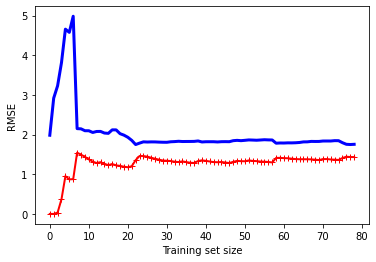

In [26]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

We plot a learning curve for the linear model first using Scikit-Learn's **LinearRegression** class. Looking at the performance on the training data, the model has zero error for the first few instances and then it rises as it encounters more instances before it eventually plateaus out. On the validation set, the model has a very high error for the first few instances since it cannot generalize and then eventually after it encounters more instances it slowly goes down. However, once again, a straight line cannot do a good job modeling the data, so error ends up at a plateau very close to the other curve.

These learning curves are typical of a model that's underfitting. Both curves have reached a plateau; they are close and fairly high.

If your model is underfitting the data, adding more training examples will not help. You need to use a more complex model or come up with better features.

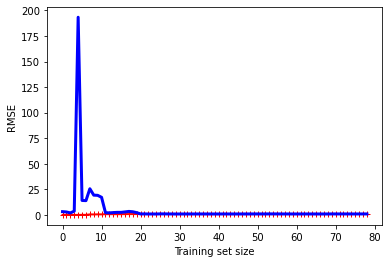

In [27]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=4, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

We now look at the learning curve for a 4 degree polynomial on the same data. 

These curves look a bit like the previous ones but there are two very important differences:

1. The error on the training data is much lower than with the Linear Regression model.
2. There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If we used a much larger training set however, the two curves would continue to get closer.

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

### The Bias/Variance Trade-off

A model's generalization error can be expressed as the sum of three very different errors:

1. *Bias* : This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.
2. *Variance* : This part is due to the model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as high-degree polynomial model) is likely to have high variance and thus overfit the training data.
3. *Irreducible error* : This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g. fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model's complexity will typically increase its variance and reduce its bias. Conversely, reducing a model's complexity increases its bias and reduces its variance. This is why it's called a trade-off.

# Regularized Linear Models

A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. 

### Ridge Regression

*Ridge Regression* is a regularized version of Linear Regression: a *regularization term* equal to $\alpha \sum_{i=1}^{n} \theta_{i}^{2}$ is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. The regularization term should only be added to the cost function during training. Once the model is trained, we use the unregularized performance measure to evaluate the model's performance.

It is common for the cost function used during training to be different from the performance measures used for testing. Apart from regularization, another reason they are different is that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective. For example, classifiers are often trained using a cost function such as log loss but evaluated using precision/recall.

The hyperparameter $\alpha$ controls how much we want to regularize the model. If $\alpha = 0$, then Ridge Regression is just Linear Regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean. The cost function of Ridge Regression is given by:

$J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum_{i=1}^{n} \theta_{i}^{2}$

The bias term $\theta_{0}$ is not regularized. We can define $w$ was the vector of feature weights, then the regularization term is equal to $\frac{1}{2}(||w||_{2})^{2}$ where $||w||_{2}$ represents the $l_{2}$ norm of the weight vector. For Gradient Descent, just add $\alpha w$ to the MSE Gradient vector.

It is important to scale the data before performing Ridge Regression as it is sensitive to the scale of the input features. This is true of most regularized models.

Performing Ridge Regression with Scikit-Learn using a closed form solution

In [28]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.15035247]])

Performing Ridge Regression using Stochastic Gradient Descent

In [29]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.13882773])

### Lasso Regression

*Least Absolute Shrinkage and Selection Operator Regression* or *Lasso Regression* is another regularized version of Linear Regression, it uses the $l_{1}$ norm instead of the $l_{2}$ norm in the cost function.

Cost function of Lasso Regression:

$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^{n} |\theta_{i}|$

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e. set them to zero).Lasso Regression automatically performs feature selection and outputs a *sparse model* (i.e. with few nonzero feature weights).

In [30]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.11075326])

### Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a mix of both Ridge and Lasso Regression's regularization terms, and can be controlled by the mix ratio *r*. When $r=0$, Elastic Net is equivalent to Ridge Regression and when $r=1$ it is equivalent to Lasso Regression. The cost function looks like:

$J(\theta) = MSE(\theta) + r \alpha \sum_{i=1}^{n} |\theta_{i}| + \frac{1-r}{2} \alpha \sum_{i=1}^{n} \theta_{i}^{2}$

In [31]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.11005775])

### Early Stopping

Another way to regularize iterative learning algorithms like Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called *early stopping*.

In [32]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) #continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

With **warm_start=True**, when the fit() method is caalled it continues training where it left off, instead of starting from scratch.

# Logistic Regression

Some regression algorithms can be used for classification and vice versa. *Logistic Regression* is ued to estimate the probability that an instance belongs to a particular class. If the estimated probability is greater than 50% then the model predicts that it belongs to that class, otherwise it does not. This makes it a binary classifier.

### Estimating Probabilities

Just like a Linear Regression model, Logistic Regression model computes a weighted sum of the input features plus a bias term, but instead of outputting the result directly, it outputs the *logistic* of this result. Logistic regression estimated probability:

$\hat{p} = h_{\theta}(x) = \sigma (x^{T} \theta)$

The logistic - $\sigma$ - is a *sigmoid function* that outputs a number between 0 and 1. It is defined as:

$\sigma (t) = \frac{1}{1 + exp(-t)}$

Once a Logistic Regression model has estimated the probability $\hat{p} = h_{\theta} (x)$ that an instance **x** belongs to the positive class, it can make its predictions $\hat{y}$ easily:

if $\hat{p} < 0.5, \hat{y} = 0$

if $\hat{p} \geq 0.5, \hat{y} = 1$

We can see that $\sigma (t) < 0.5$ when t < 0, and $\sigma (t) \geq 0.5$ when $t \geq 0$, so a Logistic Regression model predicts 1 if $x^{T} \theta$ is positive and 0 if it is negative.

### Training and Cost Function

The cost function of a single training instance for Logistic Regression is:

$if y = 1, c(\theta) = -log(\hat{p})$

$if y = 0, c(\theta) = -log(1-\hat{p})$

The cost function makes sense because $-log(t)$ grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance. On the other hand, $-log(t)$ is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance.

The cost function over the entire training set is just the average cost over all training instances. It is called the *log loss* and is written as:

$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} log(\hat{p}^{(i)}) + (1 - y^{(i)}) log (1 - \hat{p}^{(i)})]$

### Decision Boundaries

Building a classifier to detect the *Iris virginica* type based only on the petal width feature

In [33]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [34]:
X = iris["data"][:, 3:] # only petal width feature
y = (iris["target"] == 2).astype(int) # 1 if Iris virginica, else 0

In [35]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

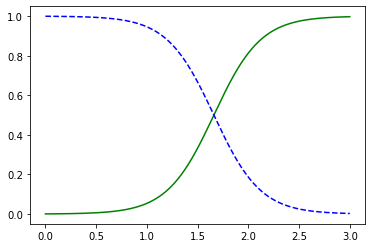

In [36]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris Virginica")

The petal width of *Iris virginica* flowers ranges from 1.4cm to 2.5cm, while the other iris flowers generally have a smaller petal width, ranging from 0.1cm to 1.8cm. There is a *decision boundary* at 1.6cm.

In [37]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Just like other linear models, Logistic Regression models can be regularized using $l_{1}$ or $l_{2}$ penalties. Scikit-Learn adds an $l_{2}$ penalty by default.

The hyperparameter controlling the regularization strength of a Scikit-Learn LogisticRegression model is not alpha, but its inverse **C**. The higher the value of C, the *less* the model is regularized.

### Softmax Regression

The Logistic Regression model can be generalized to support multiple classses directly, without having to train and combine multiple binary classifiers. This is called *Softmax Regression* or *Multinomial Logistic Regression*.

When given an instance **x**, the Softmax Regression model first computes a score $s_{k}(x)$ for each class k, then estimates the probability of each class by applying the *softmax function* to the scores. The equation to compute $s_{k}(x)$:

$s_{k}(x) = x^{T} \theta^{(k)}$

Each class has its own dedicated parameter vector $\theta^{(k)}$. All these vectors are stored as rows in a *parameter matrix*, $\Theta$

Once the score of every class for an instance x has been computed, we can estimate the probability $\hat{p}_{k}$ that the instance belongs to class k by running the scores through the softmax function. The function computes the exponential of every score then normalizes them (dividing by the sum of all the exponentials). The scores are generally called logits or log-odds. Softmax function:

$\hat{p}_{k} = \sigma (s(x))_{k} = \frac{exp(s_{k}(x))}{\sum_{j=1}^{K} exp (s_{j}(x))}$

In this Equation:

1. K is the number of classes
2. s(x) is a vector containing the scores of each class for the instance x
3. $\sigma(s(x))_{k}$ is the estimated probability that the instance x belongs to the class k, given the scores of each class for that instance.

The Softmax Regression classifier predicts the class with the highest estimated probability.

$\hat{y} = argmax_{k} \sigma (s(x))_{k} = argmax_{k} s_{k}(x) = argmax_{k} ((\theta^{(k)})^{T} x)$

The *argmax* operator returns the value of a variable that maximizes a function. 

The *cross entropy* is used to train and measure how well a set of estimated class probabilites match the target class.

$J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} log(\hat{p}_{k}^{(i)})$

In this equation:

1. $y_{k}^{(i)}$ is the target probability that the $i^{th}$ instance belongs to the class k. It is equal to either 0 or 1, depending on if the instance belongs to the class or not.

The gradient vector of this cost function is given by:

$\triangledown_{\theta^{(k)}} J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (\hat{p}_{k}^{(i)} - y_{k}^{(i)}) x^{(i)}$

Scikit-Learn's *LogisticRegression* uses OvR by default when trained on more than two classes but we can set the **multi_class** hyperparameter to "multinomial" to switch it to Softmax Regression. We must also specify a solver that supports Softmax Regression such as the "lbfgs" solver. It also applies the regularization by default which can be controlled with the C hyperparameter.

In [38]:
X = iris["data"][:, (2, 3)] # petal length, petal width
y = iris["target"]

In [39]:
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [40]:
softmax_reg.predict([[5, 2]])

array([2])

In [41]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])